In [51]:
import time
import sys
import os
import numpy as np
import random
import networkx as nx
import pandas as pd
import seaborn as sb
from collections import defaultdict
from matplotlib import pyplot as plt

sys.path.insert(0, os.path.join(os.getcwd(), "..", "cpp_prim", "x64", "Release"))
sys.path.insert(0, os.path.join(os.getcwd(), "..", "py_prim"))
import py_prim
import cpp_prim

In [52]:
def plot_timing(ax, cpp_time, py_time, nodes, title=""):
    ax.plot(nodes, cpp_time, label='C++')
    ax.plot(nodes, py_time, label='Python')
    ax.set_xlabel('Liczba wierzchołków')
    ax.set_ylabel('Średni czas wykonania [s]')
    ax.set_title(title)
    ax.legend()

### Test on complete graphs

In [3]:
def generate_complete_graph(nodesNum):
    graph = nx.complete_graph(nodesNum)
    for (start, end) in graph.edges:
        graph.edges[start, end]['weight'] = random.randrange(1, 100)
    return graph

In [4]:
def test_on_complete_graph(prim_impl, nodes_range = range(10, 510, 10), iterations_per_node_number = 100):
    elapsed_time = []
    nodes_num = []
    for nodes in list(nodes_range):
        execution_time = 0
        for test in list(range(0, iterations_per_node_number, 1)):
            print(f"Complete graph with {nodes} nodes. Iteration {test + 1} in {iterations_per_node_number}", end="\r")
            graph = generate_complete_graph(nodes)
            adjacency_matrix = nx.to_numpy_array(graph, dtype='int32').tolist()
            start_time = time.time()
            prim_impl.run_algorithm(adjacency_matrix)
            end_time = time.time()
            execution_time += end_time - start_time  
        nodes_num.append(nodes)
        elapsed_time.append(execution_time/iterations_per_node_number)
    return elapsed_time, nodes_num

In [5]:
random.seed(123)
cpp_complete_time, cpp_complete_nodes = test_on_complete_graph(cpp_prim)
random.seed(123)
py_complete_time, py_complete_nodes = test_on_complete_graph(py_prim)

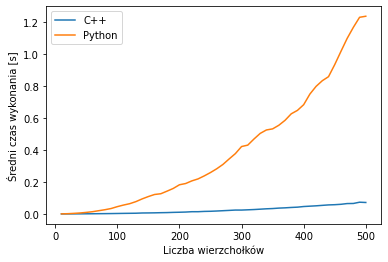

In [6]:
fig, ax = plt.subplots(1, 1)
plot_timing(ax, cpp_complete_time, py_complete_time, cpp_complete_nodes)

### Test on random trees

In [43]:
def generate_random_tree(nodesNum):
    graph = nx.random_powerlaw_tree(nodesNum, tries=100000)
    for (start, end) in graph.edges:
        graph.edges[start, end]['weight'] = random.randrange(1, 100)
    return graph

def test_on_tree(prim_impl, nodes_range = range(10, 510, 10), iterations_per_node_number = 100):
    elapsed_time = []
    nodes_num = []
    for nodes in list(nodes_range):
        execution_time = 0
        for test in list(range(0, iterations_per_node_number, 1)):
            print(f"Random tree with {nodes} nodes. Iteration {test + 1} in {iterations_per_node_number}", end="\r")
            graph = generate_random_tree(nodes)
            adjacency_matrix = nx.to_numpy_array(graph, dtype='int32').tolist()
            start_time = time.time()
            prim_impl.run_algorithm(adjacency_matrix)
            end_time = time.time()
            execution_time += end_time - start_time        
        elapsed_time.append(execution_time/iterations_per_node_number)
        nodes_num.append(nodes)
    print()
    return elapsed_time, nodes_num

In [45]:
random.seed(123)
cpp_tree_time, cpp_tree_nodes = test_on_tree(cpp_prim, nodes_range = range(10, 510, 10))
random.seed(123)
py_tree_time, py_tree_nodes = test_on_tree(py_prim,nodes_range = range(10, 510, 10))

Random tree with 500 nodes. Iteration 100 in 100
Random tree with 500 nodes. Iteration 100 in 100


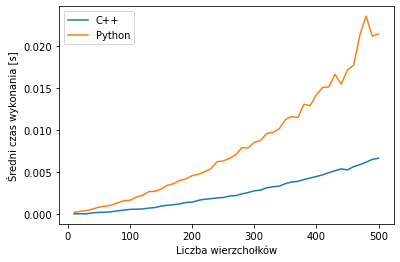

In [53]:
fig, ax = plt.subplots(1, 1)
plot_timing(ax, cpp_tree_time, py_tree_time, cpp_tree_nodes)

### Test on random graphs with different density

We use density values from 0.1 to 1.0, increasing by 0.1 in each step. Number of nodes is increased as follows: we start at 5 nodes and 10 nodes, then with each iteration we increase number of nodes by an order of magnitude (50 and 100, 500 and 1000...) to the moment when computation time exceeds 12h. 

In [10]:
random.seed(123)
cpp_results = {}
python_results = {}

In [11]:
def test(nodes, density, repeat, result_dict, impl):
    test_count = 0
    if nodes not in result_dict:
        result_dict[nodes] = {}
    
    summary_time = 0
    while test_count < repeat :
        print(f"Nodes {nodes}, density {density}. Test {test_count} of {repeat}.", end="\r")
        graph = nx.fast_gnp_random_graph(nodes, density)
        
        if not nx.is_connected(graph):
            continue
            
        for (start, end) in graph.edges:
            graph.edges[start, end]['weight'] = random.randrange(1, 100)
        
        matrix = nx.to_numpy_array(graph, dtype='int32').tolist()
        start = time.time()
        impl.run_algorithm(matrix)
        end = time.time()
        
        summary_time = summary_time + (end - start)
        test_count = test_count + 1
    result_dict[nodes][density] = summary_time / repeat

In [12]:
def test_cpp(nodes, density, repeat = 100):
    test(nodes, density, repeat, cpp_results, cpp_prim)

In [13]:
def test_python(nodes, density, repeat = 100):
    test(nodes, density, repeat, python_results, py_prim)

In [14]:
for p in range(1, 11, 1):
    test_cpp(5, p / 10)

print(cpp_results)

Nodes 5, density 0.1. Test 7 of 100.

Nodes 5, density 0.1. Test 16 of 100.

Nodes 5, density 0.1. Test 21 of 100.

Nodes 5, density 0.1. Test 33 of 100.

Nodes 5, density 0.1. Test 56 of 100.

Nodes 5, density 0.1. Test 66 of 100.

Nodes 5, density 0.1. Test 89 of 100.

Nodes 5, density 0.3. Test 53 of 100.

Nodes 5, density 0.9. Test 12 of 100.

{5: {0.1: 3.990650177001953e-05, 0.2: 1.996278762817383e-05, 0.3: 0.0, 0.4: 9.95635986328125e-06, 0.5: 9.918212890625e-06, 0.6: 1.9955635070800782e-05, 0.7: 3.979682922363281e-05, 0.8: 1.9941329956054688e-05, 0.9: 9.973049163818359e-06, 1.0: 1.972198486328125e-05}}


In [15]:
for p in range(1, 11, 1):
    test_cpp(10, p / 10)

print(cpp_results)

Nodes 10, density 0.1. Test 5 of 100.

Nodes 10, density 0.1. Test 23 of 100.

Nodes 10, density 0.1. Test 34 of 100.

Nodes 10, density 0.1. Test 44 of 100.

Nodes 10, density 0.1. Test 52 of 100.

Nodes 10, density 0.1. Test 62 of 100.

Nodes 10, density 0.2. Test 42 of 100.

Nodes 10, density 0.6. Test 7 of 100.

Nodes 10, density 0.9. Test 79 of 100.

{5: {0.1: 3.990650177001953e-05, 0.2: 1.996278762817383e-05, 0.3: 0.0, 0.4: 9.95635986328125e-06, 0.5: 9.918212890625e-06, 0.6: 1.9955635070800782e-05, 0.7: 3.979682922363281e-05, 0.8: 1.9941329956054688e-05, 0.9: 9.973049163818359e-06, 1.0: 1.972198486328125e-05}, 10: {0.1: 8.972883224487305e-05, 0.2: 8.977174758911132e-05, 0.3: 2.9964447021484377e-05, 0.4: 8.997201919555664e-05, 0.5: 5.990266799926758e-05, 0.6: 4.0099620819091796e-05, 0.7: 8.936882019042968e-05, 0.8: 4.985570907592774e-05, 0.9: 7.993698120117187e-05, 1.0: 7.979154586791993e-05}}


In [16]:
for p in range(1, 11, 1):
    test_cpp(50, p / 10)

print(cpp_results)

{5: {0.1: 3.990650177001953e-05, 0.2: 1.996278762817383e-05, 0.3: 0.0, 0.4: 9.95635986328125e-06, 0.5: 9.918212890625e-06, 0.6: 1.9955635070800782e-05, 0.7: 3.979682922363281e-05, 0.8: 1.9941329956054688e-05, 0.9: 9.973049163818359e-06, 1.0: 1.972198486328125e-05}, 10: {0.1: 8.972883224487305e-05, 0.2: 8.977174758911132e-05, 0.3: 2.9964447021484377e-05, 0.4: 8.997201919555664e-05, 0.5: 5.990266799926758e-05, 0.6: 4.0099620819091796e-05, 0.7: 8.936882019042968e-05, 0.8: 4.985570907592774e-05, 0.9: 7.993698120117187e-05, 1.0: 7.979154586791993e-05}, 50: {0.1: 0.00033919572830200197, 0.2: 0.00033902883529663086, 0.3: 0.0004066586494445801, 0.4: 0.000435483455657959, 0.5: 0.0004463768005371094, 0.6: 0.0005745697021484375, 0.7: 0.0005279159545898437, 0.8: 0.0005969619750976563, 0.9: 0.0006191325187683105, 1.0: 0.0006495547294616699}}


In [17]:
for p in range(1, 11, 1):
    test_cpp(100, p / 10)

print(cpp_results)

{5: {0.1: 3.990650177001953e-05, 0.2: 1.996278762817383e-05, 0.3: 0.0, 0.4: 9.95635986328125e-06, 0.5: 9.918212890625e-06, 0.6: 1.9955635070800782e-05, 0.7: 3.979682922363281e-05, 0.8: 1.9941329956054688e-05, 0.9: 9.973049163818359e-06, 1.0: 1.972198486328125e-05}, 10: {0.1: 8.972883224487305e-05, 0.2: 8.977174758911132e-05, 0.3: 2.9964447021484377e-05, 0.4: 8.997201919555664e-05, 0.5: 5.990266799926758e-05, 0.6: 4.0099620819091796e-05, 0.7: 8.936882019042968e-05, 0.8: 4.985570907592774e-05, 0.9: 7.993698120117187e-05, 1.0: 7.979154586791993e-05}, 50: {0.1: 0.00033919572830200197, 0.2: 0.00033902883529663086, 0.3: 0.0004066586494445801, 0.4: 0.000435483455657959, 0.5: 0.0004463768005371094, 0.6: 0.0005745697021484375, 0.7: 0.0005279159545898437, 0.8: 0.0005969619750976563, 0.9: 0.0006191325187683105, 1.0: 0.0006495547294616699}, 100: {0.1: 0.0008472704887390137, 0.2: 0.0009920549392700194, 0.3: 0.001256864070892334, 0.4: 0.001516103744506836, 0.5: 0.0016921424865722655, 0.6: 0.00182281

In [18]:
for p in range(1, 11, 1):
    test_cpp(500, p / 10)

print(cpp_results)

{5: {0.1: 3.990650177001953e-05, 0.2: 1.996278762817383e-05, 0.3: 0.0, 0.4: 9.95635986328125e-06, 0.5: 9.918212890625e-06, 0.6: 1.9955635070800782e-05, 0.7: 3.979682922363281e-05, 0.8: 1.9941329956054688e-05, 0.9: 9.973049163818359e-06, 1.0: 1.972198486328125e-05}, 10: {0.1: 8.972883224487305e-05, 0.2: 8.977174758911132e-05, 0.3: 2.9964447021484377e-05, 0.4: 8.997201919555664e-05, 0.5: 5.990266799926758e-05, 0.6: 4.0099620819091796e-05, 0.7: 8.936882019042968e-05, 0.8: 4.985570907592774e-05, 0.9: 7.993698120117187e-05, 1.0: 7.979154586791993e-05}, 50: {0.1: 0.00033919572830200197, 0.2: 0.00033902883529663086, 0.3: 0.0004066586494445801, 0.4: 0.000435483455657959, 0.5: 0.0004463768005371094, 0.6: 0.0005745697021484375, 0.7: 0.0005279159545898437, 0.8: 0.0005969619750976563, 0.9: 0.0006191325187683105, 1.0: 0.0006495547294616699}, 100: {0.1: 0.0008472704887390137, 0.2: 0.0009920549392700194, 0.3: 0.001256864070892334, 0.4: 0.001516103744506836, 0.5: 0.0016921424865722655, 0.6: 0.00182281

In [19]:
for p in range(1, 11, 1):
    test_cpp(1000, p / 10)

print(cpp_results)

{5: {0.1: 3.990650177001953e-05, 0.2: 1.996278762817383e-05, 0.3: 0.0, 0.4: 9.95635986328125e-06, 0.5: 9.918212890625e-06, 0.6: 1.9955635070800782e-05, 0.7: 3.979682922363281e-05, 0.8: 1.9941329956054688e-05, 0.9: 9.973049163818359e-06, 1.0: 1.972198486328125e-05}, 10: {0.1: 8.972883224487305e-05, 0.2: 8.977174758911132e-05, 0.3: 2.9964447021484377e-05, 0.4: 8.997201919555664e-05, 0.5: 5.990266799926758e-05, 0.6: 4.0099620819091796e-05, 0.7: 8.936882019042968e-05, 0.8: 4.985570907592774e-05, 0.9: 7.993698120117187e-05, 1.0: 7.979154586791993e-05}, 50: {0.1: 0.00033919572830200197, 0.2: 0.00033902883529663086, 0.3: 0.0004066586494445801, 0.4: 0.000435483455657959, 0.5: 0.0004463768005371094, 0.6: 0.0005745697021484375, 0.7: 0.0005279159545898437, 0.8: 0.0005969619750976563, 0.9: 0.0006191325187683105, 1.0: 0.0006495547294616699}, 100: {0.1: 0.0008472704887390137, 0.2: 0.0009920549392700194, 0.3: 0.001256864070892334, 0.4: 0.001516103744506836, 0.5: 0.0016921424865722655, 0.6: 0.00182281

In [41]:
for p in range(1, 11, 1):
    test_cpp(5000, p / 10)

print(cpp_results)

KeyboardInterrupt: 

Computation time over 12h. Coputation was interrupted.

,5,10,50,100,500,1000
0.1,0.00004,0.000090,0.000339,0.000847,0.013729,0.053748
0.2,0.00002,0.000090,0.000339,0.000992,0.019836,0.079782
0.3,0.00000,0.000030,0.000407,0.001257,0.028075,0.107743
0.4,0.00001,0.000090,0.000435,0.001516,0.033634,0.137315
0.5,0.00001,0.000060,0.000446,0.001692,0.038823,0.174119
0.6,0.00002,0.000040,0.000575,0.001823,0.046012,0.216642
0.7,0.00004,0.000089,0.000528,0.002116,0.053186,0.244444
0.8,0.00002,0.000050,0.000597,0.002386,0.058043,0.263990
0.9,0.00001,0.000080,0.000619,0.002501,0.063478,0.284541
1.0,0.00002,0.000080,0.000650,0.002633,0.069081,0.303144


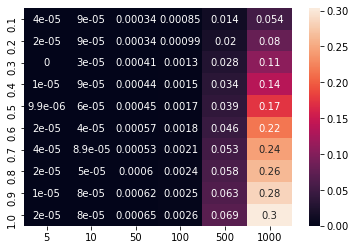

In [38]:
cpp_results.pop(5000, None) 
cpp_df = pd.DataFrame(cpp_results)
display(cpp_df)
sb.heatmap(cpp_df, annot = True)

Text(0, 0.5, 'Średni czas wykonania')

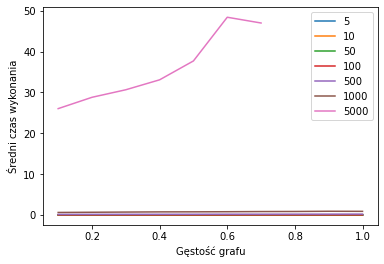

In [23]:
plt = cpp_df.plot()
plt.set_xlabel("Gęstość grafu")
plt.set_ylabel("Średni czas wykonania")

Text(0, 0.5, 'Średni czas wykonania')

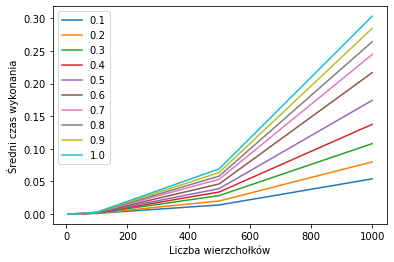

In [23]:
plt = cpp_df.T.iloc[[0, 1, 2, 3, 4, 5]].plot()
plt.set_xlabel("Liczba wierzchołków")
plt.set_ylabel("Średni czas wykonania")

In [24]:
for p in range(1, 11, 1):
    test_python(5, p / 10)

print(python_results)

Nodes 5, density 0.1. Test 23 of 100.

Nodes 5, density 0.1. Test 49 of 100.

Nodes 5, density 0.1. Test 72 of 100.

Nodes 5, density 0.1. Test 97 of 100.

Nodes 5, density 0.2. Test 70 of 100.

Nodes 5, density 1.0. Test 12 of 100.

{5: {0.1: 0.0001495528221130371, 0.2: 3.9811134338378904e-05, 0.3: 0.00010971784591674805, 0.4: 5.97691535949707e-05, 0.5: 0.00012956142425537108, 0.6: 9.969234466552734e-05, 0.7: 5.9249401092529295e-05, 0.8: 0.0001296091079711914, 0.9: 0.0001089024543762207, 1.0: 9.969711303710938e-05}}


In [25]:
for p in range(1, 11, 1):
    test_python(10, p / 10)

print(python_results)

Nodes 10, density 0.1. Test 45 of 100.

Nodes 10, density 0.1. Test 55 of 100.

Nodes 10, density 0.1. Test 59 of 100.

Nodes 10, density 0.1. Test 69 of 100.

Nodes 10, density 0.1. Test 81 of 100.

Nodes 10, density 0.1. Test 97 of 100.

Nodes 10, density 0.5. Test 84 of 100.

Nodes 10, density 0.8. Test 92 of 100.

{5: {0.1: 0.0001495528221130371, 0.2: 3.9811134338378904e-05, 0.3: 0.00010971784591674805, 0.4: 5.97691535949707e-05, 0.5: 0.00012956142425537108, 0.6: 9.969234466552734e-05, 0.7: 5.9249401092529295e-05, 0.8: 0.0001296091079711914, 0.9: 0.0001089024543762207, 1.0: 9.969711303710938e-05}, 10: {0.1: 0.00017935514450073242, 0.2: 0.00013952255249023439, 0.3: 0.00015962839126586913, 0.4: 0.00027825117111206053, 0.5: 0.00022939443588256835, 0.6: 0.00026941537857055664, 0.7: 0.00028908252716064453, 0.8: 0.00031892776489257814, 0.9: 0.00037383079528808595, 1.0: 0.0004161882400512695}}


In [26]:
for p in range(1, 11, 1):
    test_python(50, p / 10)

print(python_results)

{5: {0.1: 0.0001495528221130371, 0.2: 3.9811134338378904e-05, 0.3: 0.00010971784591674805, 0.4: 5.97691535949707e-05, 0.5: 0.00012956142425537108, 0.6: 9.969234466552734e-05, 0.7: 5.9249401092529295e-05, 0.8: 0.0001296091079711914, 0.9: 0.0001089024543762207, 1.0: 9.969711303710938e-05}, 10: {0.1: 0.00017935514450073242, 0.2: 0.00013952255249023439, 0.3: 0.00015962839126586913, 0.4: 0.00027825117111206053, 0.5: 0.00022939443588256835, 0.6: 0.00026941537857055664, 0.7: 0.00028908252716064453, 0.8: 0.00031892776489257814, 0.9: 0.00037383079528808595, 1.0: 0.0004161882400512695}, 50: {0.1: 0.0018668055534362793, 0.2: 0.0026563286781311037, 0.3: 0.003427143096923828, 0.4: 0.04494828462600708, 0.5: 0.005724809169769287, 0.6: 0.005985093116760254, 0.7: 0.016284701824188234, 0.8: 0.01696528196334839, 0.9: 0.01761178970336914, 1.0: 0.02890833854675293}}


In [27]:
for p in range(1, 11, 1):
    test_python(100, p / 10)

print(python_results)

{5: {0.1: 0.0001495528221130371, 0.2: 3.9811134338378904e-05, 0.3: 0.00010971784591674805, 0.4: 5.97691535949707e-05, 0.5: 0.00012956142425537108, 0.6: 9.969234466552734e-05, 0.7: 5.9249401092529295e-05, 0.8: 0.0001296091079711914, 0.9: 0.0001089024543762207, 1.0: 9.969711303710938e-05}, 10: {0.1: 0.00017935514450073242, 0.2: 0.00013952255249023439, 0.3: 0.00015962839126586913, 0.4: 0.00027825117111206053, 0.5: 0.00022939443588256835, 0.6: 0.00026941537857055664, 0.7: 0.00028908252716064453, 0.8: 0.00031892776489257814, 0.9: 0.00037383079528808595, 1.0: 0.0004161882400512695}, 50: {0.1: 0.0018668055534362793, 0.2: 0.0026563286781311037, 0.3: 0.003427143096923828, 0.4: 0.04494828462600708, 0.5: 0.005724809169769287, 0.6: 0.005985093116760254, 0.7: 0.016284701824188234, 0.8: 0.01696528196334839, 0.9: 0.01761178970336914, 1.0: 0.02890833854675293}, 100: {0.1: 0.006739630699157715, 0.2: 0.019144563674926757, 0.3: 0.03288053512573242, 0.4: 0.044985439777374264, 0.5: 0.07658397674560546, 0.6

In [28]:
for p in range(1, 11, 1):
    test_python(500, p / 10)

print(python_results)

{5: {0.1: 0.0001495528221130371, 0.2: 3.9811134338378904e-05, 0.3: 0.00010971784591674805, 0.4: 5.97691535949707e-05, 0.5: 0.00012956142425537108, 0.6: 9.969234466552734e-05, 0.7: 5.9249401092529295e-05, 0.8: 0.0001296091079711914, 0.9: 0.0001089024543762207, 1.0: 9.969711303710938e-05}, 10: {0.1: 0.00017935514450073242, 0.2: 0.00013952255249023439, 0.3: 0.00015962839126586913, 0.4: 0.00027825117111206053, 0.5: 0.00022939443588256835, 0.6: 0.00026941537857055664, 0.7: 0.00028908252716064453, 0.8: 0.00031892776489257814, 0.9: 0.00037383079528808595, 1.0: 0.0004161882400512695}, 50: {0.1: 0.0018668055534362793, 0.2: 0.0026563286781311037, 0.3: 0.003427143096923828, 0.4: 0.04494828462600708, 0.5: 0.005724809169769287, 0.6: 0.005985093116760254, 0.7: 0.016284701824188234, 0.8: 0.01696528196334839, 0.9: 0.01761178970336914, 1.0: 0.02890833854675293}, 100: {0.1: 0.006739630699157715, 0.2: 0.019144563674926757, 0.3: 0.03288053512573242, 0.4: 0.044985439777374264, 0.5: 0.07658397674560546, 0.6

In [29]:
for p in range(1, 11, 1):
    test_python(1000, p / 10)

print(python_results)

{5: {0.1: 0.0001495528221130371, 0.2: 3.9811134338378904e-05, 0.3: 0.00010971784591674805, 0.4: 5.97691535949707e-05, 0.5: 0.00012956142425537108, 0.6: 9.969234466552734e-05, 0.7: 5.9249401092529295e-05, 0.8: 0.0001296091079711914, 0.9: 0.0001089024543762207, 1.0: 9.969711303710938e-05}, 10: {0.1: 0.00017935514450073242, 0.2: 0.00013952255249023439, 0.3: 0.00015962839126586913, 0.4: 0.00027825117111206053, 0.5: 0.00022939443588256835, 0.6: 0.00026941537857055664, 0.7: 0.00028908252716064453, 0.8: 0.00031892776489257814, 0.9: 0.00037383079528808595, 1.0: 0.0004161882400512695}, 50: {0.1: 0.0018668055534362793, 0.2: 0.0026563286781311037, 0.3: 0.003427143096923828, 0.4: 0.04494828462600708, 0.5: 0.005724809169769287, 0.6: 0.005985093116760254, 0.7: 0.016284701824188234, 0.8: 0.01696528196334839, 0.9: 0.01761178970336914, 1.0: 0.02890833854675293}, 100: {0.1: 0.006739630699157715, 0.2: 0.019144563674926757, 0.3: 0.03288053512573242, 0.4: 0.044985439777374264, 0.5: 0.07658397674560546, 0.6

,5,10,50,100,500,1000
0.1,0.000150,0.000179,0.001867,0.006740,0.592779,2.007597
0.2,0.000040,0.000140,0.002656,0.019145,1.150625,3.508604
0.3,0.000110,0.000160,0.003427,0.032881,1.649524,4.654974
0.4,0.000060,0.000278,0.044948,0.044985,2.059422,5.596001
0.5,0.000130,0.000229,0.005725,0.076584,2.458770,6.352559
0.6,0.000100,0.000269,0.005985,0.099355,2.895106,7.306469
0.7,0.000059,0.000289,0.016285,0.119095,3.119282,7.910172
0.8,0.000130,0.000319,0.016965,0.154551,3.385657,9.420388
0.9,0.000109,0.000374,0.017612,0.187507,3.645099,10.127150
1.0,0.000100,0.000416,0.028908,0.210083,4.010340,10.365336


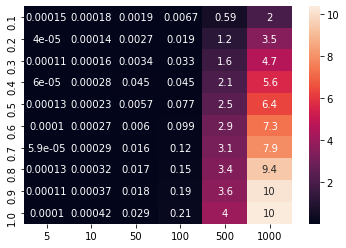

In [28]:
py_df = pd.DataFrame(python_results)
display(py_df)
sb.heatmap(py_df, annot = True)

#### Comparison of cpp and python execution time

In [ ]:
plt = cpp_df.iloc[0:4].T.plot()
plt.set_ylim([0, 2])
plt.set_xlim([0, 1000])
plt.set_xlabel("Liczba wierzchołków")
plt.set_ylabel("Średni czas wykonania")

Text(0, 0.5, 'Średni czas wykonania')

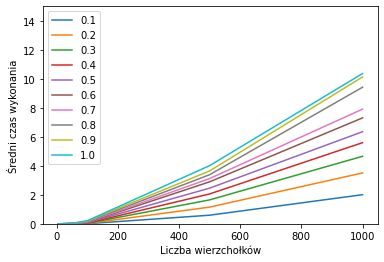

In [43]:
plt = py_df.T.plot()
plt.set_ylim([0, 15])
plt.set_xlabel("Liczba wierzchołków")
plt.set_ylabel("Średni czas wykonania")

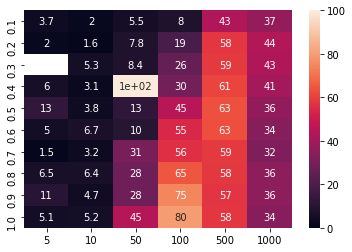

In [40]:
speed_increase = py_df.div(cpp_df, axis=0)
sb.heatmap(speed_increase, annot = True, vmax = 100, vmin = 0)